In [1]:
from transformers import PreTrainedTokenizerFast
import math
import numpy as np
import matplotlib.pyplot as plt

tokenizer = PreTrainedTokenizerFast(tokenizer_file="tiny-tokenizer.json")
tokenizer.add_special_tokens({
    "pad_token": "[PAD]",
    "unk_token": "[UNK]",
    "cls_token": "[CLS]",
    "sep_token": "[SEP]",
    "mask_token": "[MASK]"
})
import wandb
import torch.nn.init as init
import math

from datasets import load_dataset, Dataset
from transformers import DataCollatorForLanguageModeling
from transformers import BertConfig

from custom_bert_model import CustomBertForMaskedLM


import torch


/u/a/agiorlan/miniconda3/envs/torchenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load dataset
dataset = load_dataset("roneneldan/TinyStories")

# Tokenization function
def tokenize(examples):
    return tokenizer(examples["text"])

# Apply tokenizer
tokenized_dataset = dataset.map(
    tokenize,
    batched=True,
    remove_columns=["text"],
)    
all_tokens = []
for tokens in tokenized_dataset["train"]["input_ids"]:
    all_tokens.extend(tokens)
    if len(all_tokens) >= 10240:
        all_tokens = all_tokens[:10240]
        break


def get_sequence_dataloader(seq_length, batch_size=1, mlm_probability=0.05):
    """
    Create a DataLoader that yields sequences of a fixed length.
    """
    # Flatten all token lists into a single list

    # Split into chunks of seq_length
    chunks = [
        all_tokens[i:i + seq_length]
        for i in range(0, len(all_tokens), seq_length)
        if len(all_tokens[i:i + seq_length]) == seq_length
    ]

    # Convert to HuggingFace Dataset
    chunked_dataset = Dataset.from_dict({'input_ids': chunks})

    # Data collator for masked language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=True,
        mlm_probability=mlm_probability,
    )

    # Create DataLoader
    data_loader = torch.utils.data.DataLoader(
        chunked_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=data_collator,
    )

    return data_loader

In [ ]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_model(beta, d, seq_length):

    config = BertConfig(
    hidden_act="relu",
    hidden_size=d,
    intermediate_size=d,
    max_position_embeddings=seq_length,
    num_attention_heads=1,
    num_hidden_layers=1,
    position_embedding_type="absolute",
    vocab_size=tokenizer.vocab_size,
)

    model = CustomBertForMaskedLM(config, alpha_attention=1, alpha_ffn=1).to(device)
    print(f"Model has {model.num_parameters():,} parameters.")

    def rescaled_initialization(weight, beta, config=config):
        d = config.hidden_size
        T = config.max_position_embeddings
        num_heads = config.num_attention_heads
        d_H = d // num_heads
        custom_std = math.sqrt(beta) * math.log(T)**0.25 / math.sqrt(d_H)
        init.normal_(weight, mean=0.0, std=custom_std)

    Rem_rescaling = True
    if Rem_rescaling:
        for i, layer in enumerate(model.bert.encoder.layer):
            attention_layer = layer.attention.self
            rescaled_initialization(attention_layer.query.weight, beta = beta)
            rescaled_initialization(attention_layer.key.weight, beta = beta)


    remove_affine = True
    if remove_affine: 
        model.bert.embeddings.word_embeddings.bias = None
        model.bert.embeddings.position_embeddings.bias = None
        model.bert.embeddings.LayerNorm.elementwise_affine = False
        for layer in model.bert.encoder.layer:
            layer.attention.output.LayerNorm.elementwise_affine = False
            layer.attention.self.query.bias = None
            layer.attention.self.key.bias = None
            layer.output.LayerNorm.elementwise_affine = False
            

    var_w = 0.2
    var_b = 4e-4
    var_v = var_w
    custom_init = True
    if custom_init:
        embedding_dim = config.hidden_size
        sigma_b = math.sqrt(var_b)
        sigma_w = math.sqrt(var_w/embedding_dim)
        sigma_V = math.sqrt(var_v/embedding_dim)

        model.bert.embeddings.word_embeddings.weight.data.normal_(mean=0.0, std=0.01)
        model.bert.embeddings.position_embeddings.weight.data.normal_(mean=0.0, std=0.05)
        for layer in model.bert.encoder.layer:
            layer.attention.self.value.weight.data.normal_(mean=0.0, std=sigma_V)
            layer.attention.self.value.bias.data.normal_(mean=0.0, std=sigma_b)
            layer.intermediate.dense.weight.data.normal_(mean=0.0, std=sigma_w)
            layer.intermediate.dense.bias.data.normal_(mean=0.0, std=sigma_b)
            layer.output.dense.weight.data.normal_(mean=0.0, std=sigma_w)
            layer.output.dense.bias.data.normal_(mean=0.0, std=sigma_b)
    
    return model

# Getting Gradients

In [ ]:
def get_query_grad_norm(beta, d, T):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_model(beta, d, seq_length=T)
    model = model.to(device)

    query_layer = model.bert.encoder.layer[0].attention.self.query
    pos_layer = model.bert.embeddings.position_embeddings
    word_layer = model.bert.embeddings.word_embeddings
    # get loss
    data_loader = get_sequence_dataloader(seq_length=T)
    batch = next(iter(data_loader))

    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
    loss = outputs.loss

    # Getting Gradients
    model.zero_grad()
    loss.backward()

    query_grad = query_layer.weight.grad
    query_grad = query_grad.cpu().detach().numpy()
    query_grad_norm = np.linalg.norm(query_grad)

    pos_grad = pos_layer.weight.grad
    pos_grad = pos_grad.cpu().detach().numpy()
    pos_grad_norm = np.linalg.norm(pos_grad)

    word_grad = word_layer.weight.grad
    word_grad = word_grad.cpu().detach().numpy()
    word_grad_norm = np.linalg.norm(word_grad)

    return query_grad_norm, pos_grad_norm, word_grad_norm


# Trying different T's

# Joint Plot

In [ ]:
ds = [256, 512]
Ts = [2048, 4096]

beta_values = np.linspace(0.01, 3.0, 15)
results = {}

for T in Ts:
    results[T] = {}
    grad_norms_dict = { 'query': {}, 'pos': {} , 'word': {}, 'query_std': {}, 'pos_std': {}, 'word_std': {} }
    for d in ds:
        query_grad_norms = []
        pos_grad_norms = []
        word_grad_norms = []
        query_grad_norms_std = []
        pos_grad_norms_std = []
        word_grad_norms_std = []
        for beta in beta_values:
            trial_query_norms = []
            trial_pos_norms = []
            trial_word_norms = []
            for _ in range(10):
                query_grad, pos_grad, word_grad = get_query_grad_norm(beta, d=d, T=T)
                trial_query_norms.append(query_grad)
                trial_pos_norms.append(pos_grad)
                trial_word_norms.append(word_grad)
            query_grad_norms.append(np.mean(trial_query_norms))
            pos_grad_norms.append(np.mean(trial_pos_norms))
            word_grad_norms.append(np.mean(trial_word_norms))
            query_grad_norms_std.append(np.std(trial_query_norms))
            pos_grad_norms_std.append(np.std(trial_pos_norms))
            word_grad_norms_std.append(np.std(trial_word_norms))
        grad_norms_dict['query'][d] = query_grad_norms
        grad_norms_dict['pos'][d] = pos_grad_norms
        grad_norms_dict['word'][d] = word_grad_norms
        grad_norms_dict['query_std'][d] = query_grad_norms_std
        grad_norms_dict['pos_std'][d] = pos_grad_norms_std
        grad_norms_dict['word_std'][d] = word_grad_norms_std
    results[T] = grad_norms_dict

Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model has 1,435,600 parameters.
Model ha

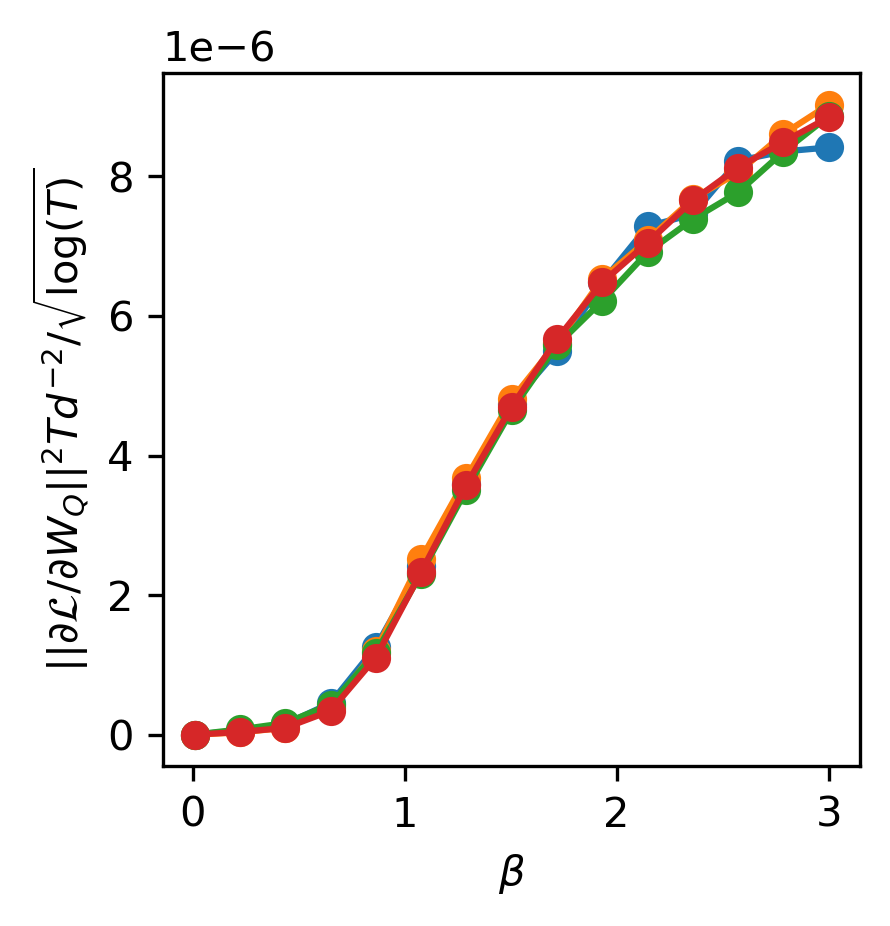

In [ ]:
plt.figure(figsize=(3, 3), dpi=300)
for T in Ts:
    for d in ds:
        scaling = T/d**2/math.sqrt(math.log(T))
        plt.plot(beta_values, np.array(results[T]['query'][d])**2 * scaling, marker='o', label=f"T={T}, d={d}")


#plt.plot(beta_values, 1.2e-4 * np.maximum(0, 1 - math.sqrt(2) / beta_values))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$||\partial \mathcal{L}/\partial W_{Q}||^{2} T d^{-2} / \sqrt{\log(T)}$")
#plt.legend(fontsize=7, loc='upper left')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
plt.show()

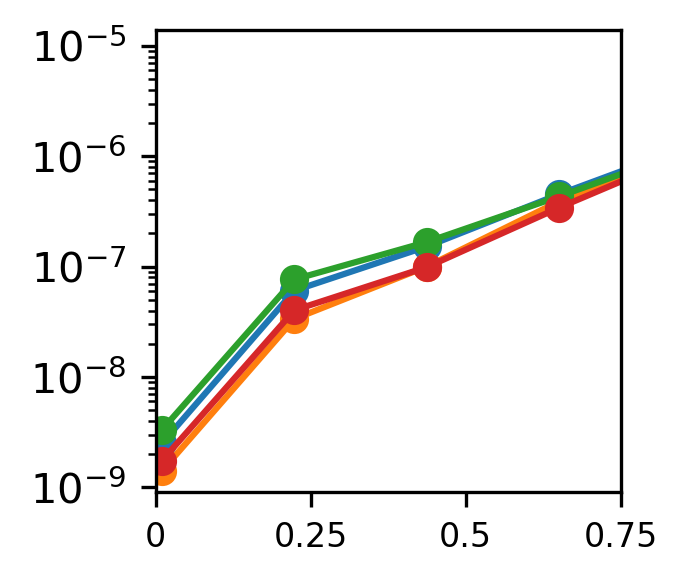

In [ ]:
plt.figure(figsize=(2, 2), dpi=300)
for T in Ts:
    for d in ds:
        plt.plot(beta_values, np.array(results[T]['query'][d])**2*T/d**2/math.sqrt(math.log(T)), marker='o', label=f"T={T}, d={d}")
plt.xlim(0, 0.7)
#plt.xlabel(r"$\beta$")
#plt.ylabel(r"$||\frac{\partial \mathcal{L}}{\partial W_{Q}}||^{2} T d^{-2}$")
#plt.legend(fontsize=8)
plt.yscale('log')
plt.xticks([0, 0.25, 0.5, 0.75], ["0", "0.25", "0.5", "0.75"], fontsize=8)
plt.show()

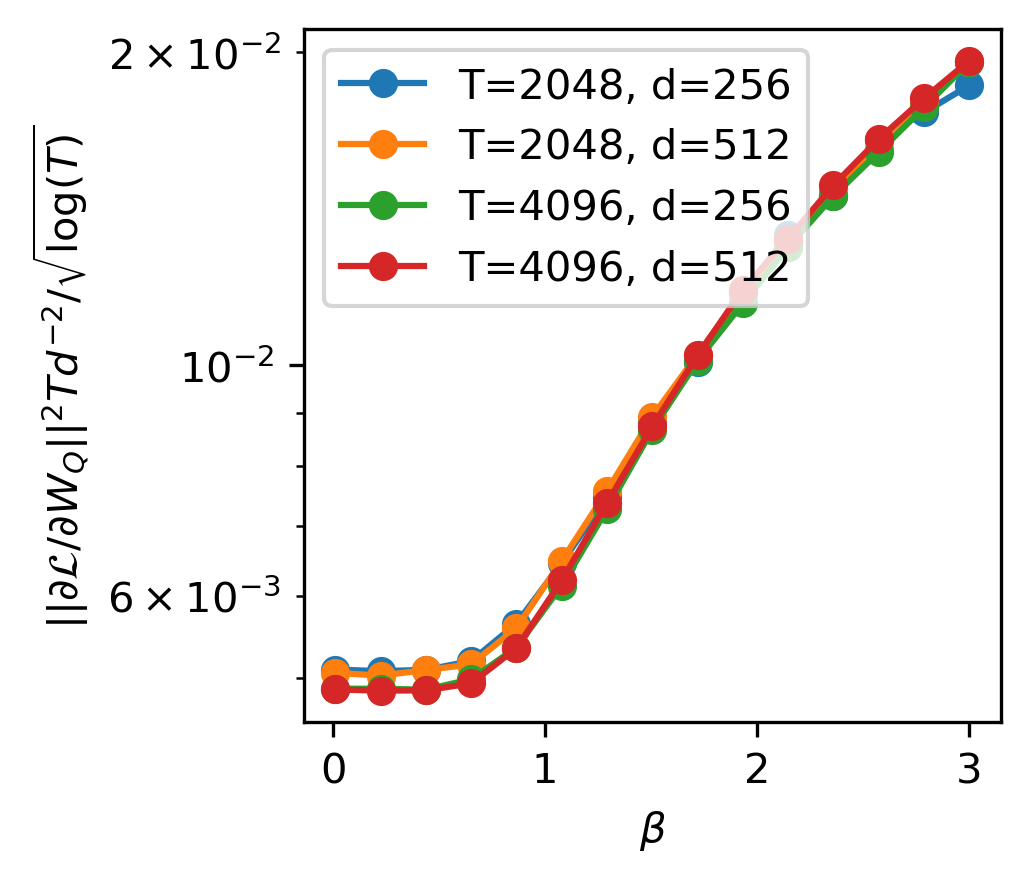

In [ ]:
plt.figure(figsize=(3, 3), dpi=300)
for T in Ts:
    for d in ds:
        plt.plot(beta_values, np.array(results[T]['pos'][d])**2*T/d/math.sqrt(math.log(T)), marker='o', label=f"T={T}, d={d}")


#plt.plot(beta_values, 1.2e-4 * np.maximum(0, 1 - math.sqrt(2) / beta_values))
plt.xlabel(r"$\beta$")
plt.ylabel(r"$||\partial \mathcal{L}/\partial W_{Q}||^{2} T d^{-2} / \sqrt{\log(T)}$")
#plt.legend(fontsize=7, loc='upper left')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
plt.legend()
plt.yscale('log')
plt.show()

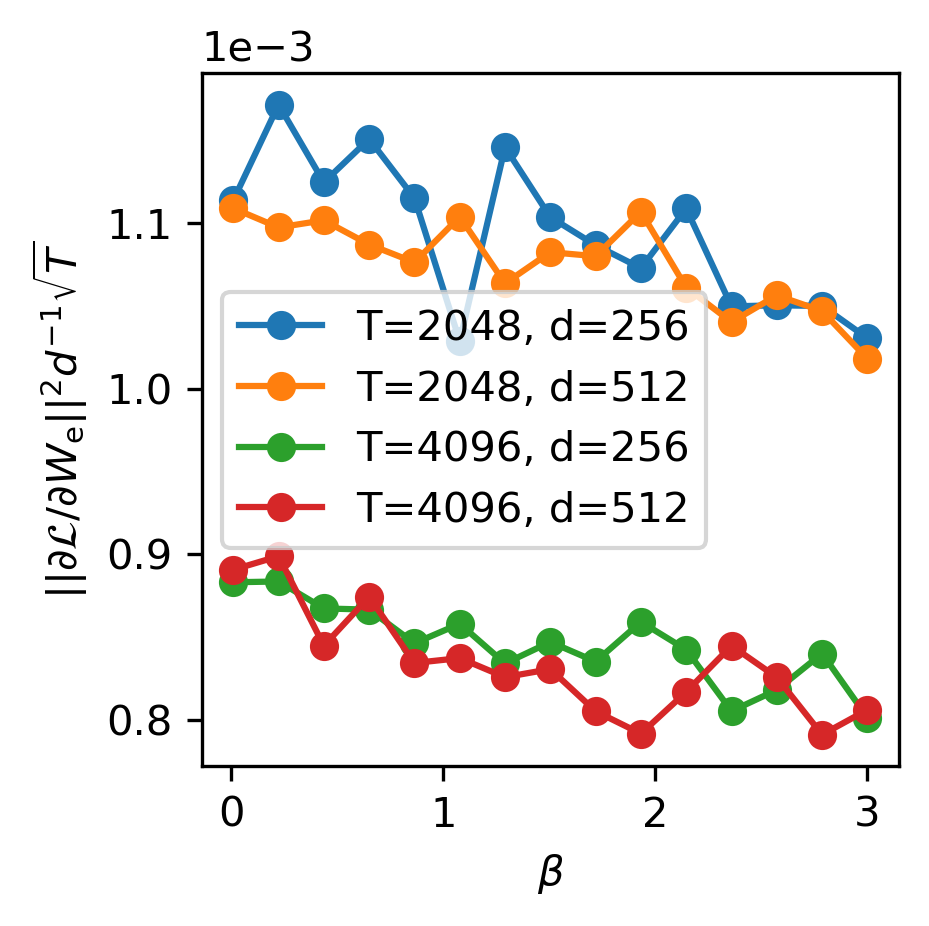

In [ ]:
plt.figure(figsize=(3, 3), dpi=300)
for T in Ts:
    for d in ds:
        plt.plot(beta_values, np.array(results[T]['word'][d])**2/d, marker='o', label=f"T={T}, d={d}")


plt.xlabel(r"$\beta$")
plt.ylabel(r"$||\partial \mathcal{L}/\partial W_{\text{e}}||^{2} d^{-1} \sqrt{T}$")
#plt.legend(fontsize=7, loc='upper left')
plt.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))

#plt.ylim(0.03, 0.04)
plt.legend()
plt.show()